In [2]:
!pip install tensorflow keras opencv-python

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import numpy as np
import os

In [4]:
!git clone https://github.com/garythung/trashnet.git

Cloning into 'trashnet'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 45 (delta 6), reused 0 (delta 0), pack-reused 33 (from 1)
Receiving objects: 100% (45/45), 40.64 MiB | 41.00 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [5]:
!unzip -q trashnet/data/dataset-resized.zip -d trashnet/data/

In [6]:
# Inspect the dataset structure
import os
data_dir = 'trashnet/data'
!ls {data_dir}

# Count the number of images in each category
for category in os.listdir(f'{data_dir}/dataset-resized'):
    if os.path.isdir(f'{data_dir}/dataset-resized/{category}'):
        print(f"{category}: {len(os.listdir(f'{data_dir}/dataset-resized/{category}'))} images")

constants.py			    one-indexed-files-notrash_train.txt
dataset-resized			    one-indexed-files-notrash_val.txt
dataset-resized.zip		    one-indexed-files.txt
__MACOSX			    resize.py
one-indexed-files-notrash_test.txt  zero-indexed-files.txt
metal: 410 images
cardboard: 403 images
glass: 501 images
plastic: 482 images
paper: 594 images
trash: 137 images


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    f'{data_dir}/dataset-resized',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    f'{data_dir}/dataset-resized',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Print the class indices to understand the mapping
print("Class indices:", train_generator.class_indices)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


TRAINING

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Create a model using MobileNetV2 as the base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=15
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 592ms/step - accuracy: 0.4344 - loss: 1.4986 - val_accuracy: 0.6417 - val_loss: 0.8792
Epoch 2/15
 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5000 - loss: 0.9844

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5000 - loss: 0.9844 - val_accuracy: 0.6562 - val_loss: 0.8614
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.7215 - loss: 0.7891 - val_accuracy: 0.6938 - val_loss: 0.7729
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.8438 - loss: 0.5850 - val_accuracy: 0.6979 - val_loss: 0.7513
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 473ms/step - accuracy: 0.7512 - loss: 0.6853 - val_accuracy: 0.6938 - val_loss: 0.7269
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.7812 - loss: 0.6261 - val_accuracy: 0.7167 - val_loss: 0.7240
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 637ms/step - accuracy: 0.7882 - loss: 0.6027 - val_accuracy: 0.7292 - val_loss: 0.7090
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8438 - loss: 0.6094 - val_accuracy: 0.7146 - val_loss: 0.7368
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 467ms/step - accuracy: 0.7992 - loss: 0.5579 - val_accuracy: 0.7417 - v

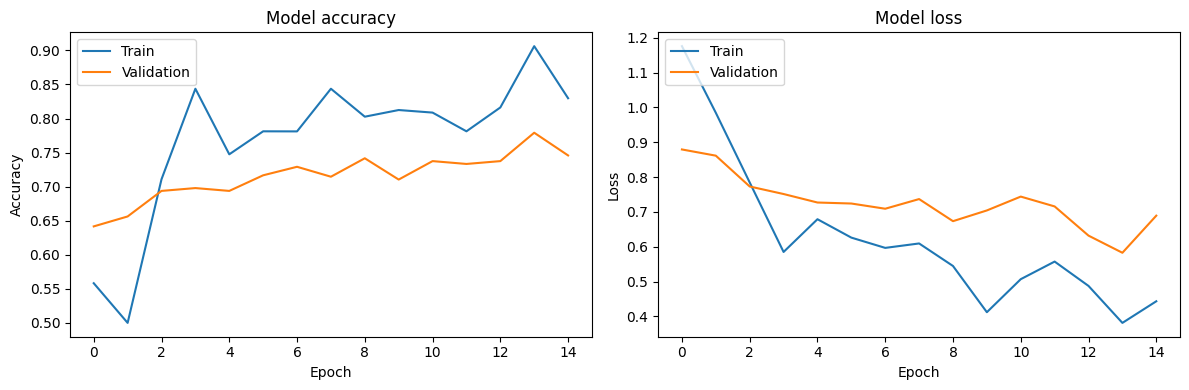

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 602ms/step - accuracy: 0.7329 - loss: 0.7401 - val_accuracy: 0.7000 - val_loss: 0.9268
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8125 - loss: 0.5668 - val_accuracy: 0.6917 - val_loss: 0.9072
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 848ms/step - accuracy: 0.8316 - loss: 0.4338 - val_accuracy: 0.7250 - val_loss: 0.8623
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.8125 - loss: 0.5801 - val_accuracy: 0.7292 - val_loss: 0.8712
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 660ms/step - accuracy: 0.8829 - loss: 0.3380 - val_accuracy: 0.7375 - val_loss: 0.8212
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8125 - loss: 0.5800 - val_accuracy: 0.7396 - val_loss: 0.8727
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.8882 - loss: 0.3131 - val_accuracy: 0.7396 - val_loss: 0.9384
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9375 - loss: 0.1438 - val_accuracy

In [12]:
# Save the entire model
model.save('my_model.keras')



PREDICT

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Actual: cardboard, Predicted: cardboard, Confidence: 0.99


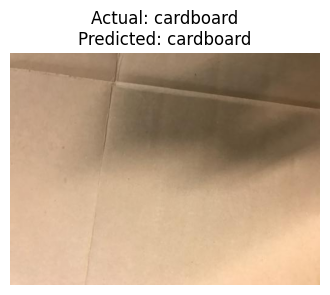

Actual: glass, Predicted: glass, Confidence: 1.00


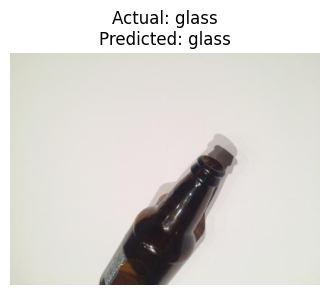

Actual: metal, Predicted: metal, Confidence: 1.00


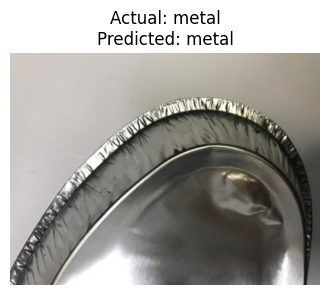

Actual: paper, Predicted: paper, Confidence: 0.99


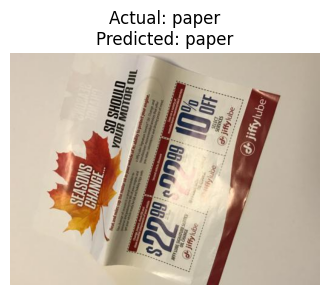

Actual: plastic, Predicted: glass, Confidence: 0.51


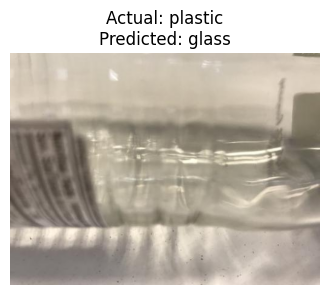

Actual: trash, Predicted: plastic, Confidence: 0.89


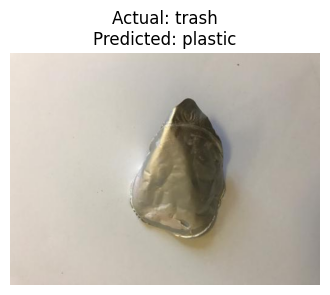

In [13]:
from tensorflow.keras.preprocessing import image

# Function to predict the class of an image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction[0])

    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_labels[class_idx]
    confidence = prediction[0][class_idx]

    return predicted_class, confidence

# Test with a few images
import random

categories = list(train_generator.class_indices.keys())
test_results = []

for category in categories:
    # Get a random image from each category
    files = os.listdir(f'{data_dir}/dataset-resized/{category}')
    random_file = random.choice(files)
    img_path = f'{data_dir}/dataset-resized/{category}/{random_file}'

    # Predict
    predicted_class, confidence = predict_image(img_path)
    test_results.append({
        'actual': category,
        'predicted': predicted_class,
        'confidence': confidence,
        'path': img_path
    })

# Display results
for result in test_results:
    print(f"Actual: {result['actual']}, Predicted: {result['predicted']}, Confidence: {result['confidence']:.2f}")
    plt.figure(figsize=(4, 4))
    plt.imshow(plt.imread(result['path']))
    plt.title(f"Actual: {result['actual']}\nPredicted: {result['predicted']}")
    plt.axis('off')
    plt.show()

Confusion Matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 672ms/step


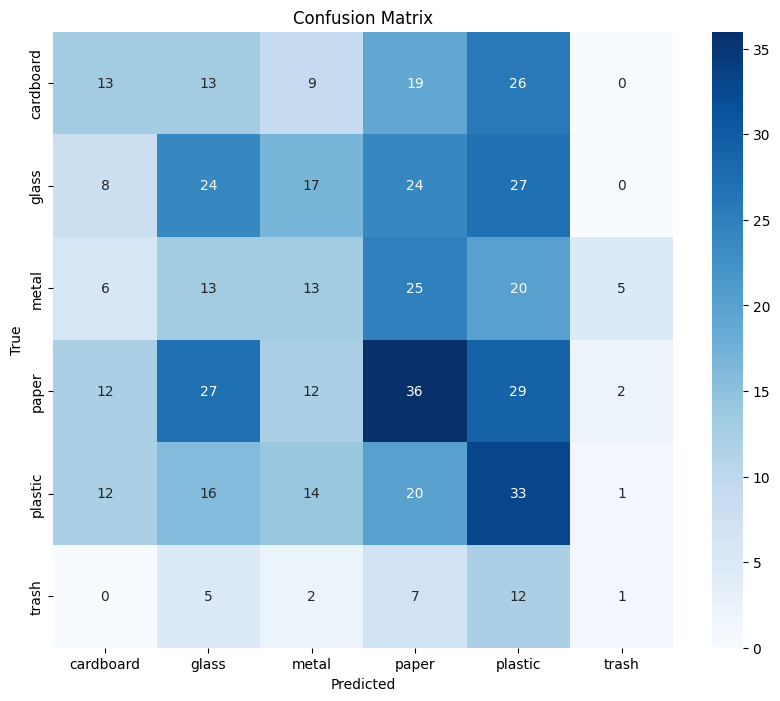

              precision    recall  f1-score   support

   cardboard       0.25      0.16      0.20        80
       glass       0.24      0.24      0.24       100
       metal       0.19      0.16      0.17        82
       paper       0.27      0.31      0.29       118
     plastic       0.22      0.34      0.27        96
       trash       0.11      0.04      0.06        27

    accuracy                           0.24       503
   macro avg       0.22      0.21      0.21       503
weighted avg       0.23      0.24      0.23       503



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation data
validation_steps = validation_generator.samples // batch_size + 1
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions[:validation_generator.samples], axis=1)

# Get true classes
true_classes = validation_generator.classes[:len(predicted_classes)]

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(
    true_classes,
    predicted_classes,
    target_names=list(train_generator.class_indices.keys())
))

In [19]:
# Create a simple function to use the model for predictions
def classify_trash(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction[0])

    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_labels[class_idx]
    confidence = prediction[0][class_idx]

    return {
        'class': predicted_class,
        'confidence': float(confidence),
        'all_probabilities': {class_labels[i]: float(prob) for i, prob in enumerate(prediction[0])}
    }

# Example usage
from google.colab import files

print("Upload an image of trash to classify:")
uploaded = files.upload()

for filename in uploaded.keys():
    result = classify_trash(filename)
    print(f"Predicted class: {result['class']}")
    print(f"Confidence: {result['confidence']:.2f}")
    print("All class probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")

Upload an image of trash to classify:


Saving tras.jpg to tras.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: cardboard
Confidence: 1.00
All class probabilities:
  cardboard: 0.9996
  glass: 0.0000
  metal: 0.0000
  paper: 0.0004
  plastic: 0.0000
  trash: 0.0000
